# Estimación del precio de venta de vehiculos
En este proyecto a partir de unas bases de datos almacenadas en ficheros csv de diferentes modelos de coches hemos realizado un estimador del precio de venta de los vehiculos.

# Imports

In [ ]:
 pip install ipython-autotime


In [ ]:
%load_ext autotime

import csv, glob, os
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, losses
from tensorflow.keras.optimizers import RMSprop

time: 1.72 s (started: 2021-06-18 13:12:18 +00:00)


# Preprocesamiento

Primero, Hemos obtenido todos los datos de los vehiculos y hemos generado un Dataframe. En este, hemos creado la columna brand a partir del nombre del csv que importabamos. Estos csv son: audi, bmw, cclass, focus, ford, hyundi, merc, skoda, toyota, vauxhall y vw.

En algunos csv hemos tenido que adaptar los datos que obteniamos ya que, por ejemplo, en el csv de cclas y en el de focus no existía la columna tax. Por otro lado, en el csv hyundi, habia un error tipografico y el valor de las tax se encontraba en libras.

## Obtener Dataframe

In [ ]:
df = pd.DataFrame()

for file in glob.glob("/content/*.csv"):
    if os.path.basename(file) == 'preprocessed-dataset.csv':
      continue

    print(file)
    file_data = pd.read_csv(file)

    # El valor de la marca se determina por el nombre del fichero sin .csv
    file_data['brand'] = os.path.basename(file[:-4])

    # El fichero cclass.csv contiene los valores para el modelo C de la marca Mercedes
    # no tiene valor para la columna tax, por lo tanto se considera que no hay impuestos
    if os.path.basename(file)=='cclass.csv':
        file_data = file_data.assign(brand='mercedes', tax=0)

    # El fichero hyundi.csv tiene un error tipografico en la marca y el valor de tax el libras
    elif os.path.basename(file)=='hyundi.csv':
        file_data = file_data.rename(columns={'tax(£)': 'tax'})
        file_data = file_data.assign(brand='hyundai')

    # El fichero cclass.csv contiene los valores para el modelo Focus de la marca Ford
    # no tiene valor para la columna tax, por lo tanto se considera que no hay impuestos
    elif os.path.basename(file)=='focus.csv':
        file_data = file_data.assign(brand='ford', tax=0)

    # El fichero merc.csv contiene los valores de la marca Mercedes
    elif os.path.basename(file)=='merc.csv':
        file_data = file_data.assign(brand='mercedes')
            
            
    df = df.append(file_data)

/content/vw.csv
/content/vauxhall.csv
/content/merc.csv
/content/skoda.csv
/content/bmw.csv
/content/audi.csv
/content/ford.csv
/content/hyundi.csv
/content/toyota.csv
/content/focus.csv
/content/cclass.csv
time: 358 ms (started: 2021-06-18 13:12:20 +00:00)


In [ ]:
print(df.head(10))

    model  year  price transmission  ...  tax   mpg  engineSize  brand
0   T-Roc  2019  25000    Automatic  ...  145  49.6         2.0     vw
1   T-Roc  2019  26883    Automatic  ...  145  49.6         2.0     vw
2   T-Roc  2019  20000       Manual  ...  145  50.4         2.0     vw
3   T-Roc  2019  33492    Automatic  ...  145  32.5         2.0     vw
4   T-Roc  2019  22900    Semi-Auto  ...  150  39.8         1.5     vw
5   T-Roc  2020  31895       Manual  ...  145  42.2         1.5     vw
6   T-Roc  2020  27895       Manual  ...  145  42.2         1.5     vw
7   T-Roc  2020  39495    Semi-Auto  ...  145  32.5         2.0     vw
8   T-Roc  2019  21995       Manual  ...  145  44.1         1.0     vw
9   T-Roc  2019  23285       Manual  ...  145  42.2         1.5     vw

[10 rows x 10 columns]
time: 22.9 ms (started: 2021-06-18 13:12:20 +00:00)


## Estudiar el conjunto de datos



## Rellenar la columna mpg de los focus y cclass
Para calcular el valor de relleno se introduce el valor de la mediana del resto de valores.

Al introducir la mediana se intenta que los valores que estan a NaN no influyan en el resultado de la regresión

In [ ]:
df.loc[((df['model'].str.contains('C Class')) | (df['model'].str.contains('Focus'))) & (df['mpg'].isnull()), 'mpg'] = df['mpg'].median(skipna=True)

time: 117 ms (started: 2021-06-18 13:12:20 +00:00)


## Adaptamos la columna de los años  
Dado que existen años mayores al año actual, para corregir este error todos aquellos años que sobrepasen el actual, se sustituyen por la media.

In [ ]:
 df.loc[df['year'] > 2021, 'year'] = df['year'].median()


time: 17.7 ms (started: 2021-06-18 13:12:20 +00:00)


In [ ]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,108540.000000,108540.000000,108540.000000,108540.000000,108540.000000,108540.000000
mean,2017.097632,16890.124046,23025.928469,109.933481,55.092130,1.661644
std,2.126073,9756.266820,21176.423684,69.166489,15.429435,0.557058
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10229.500000,7491.750000,30.000000,47.100000,1.200000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000
75%,2019.000000,20940.000000,32236.000000,145.000000,61.400000,2.000000
max,2020.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


time: 61.5 ms (started: 2021-06-18 13:12:20 +00:00)


## Guardamos el dataset en memoria

In [ ]:
df.to_csv('preprocessed-dataset.csv')

time: 534 ms (started: 2021-06-18 13:12:20 +00:00)


In [ ]:
df = pd.read_csv("preprocessed-dataset.csv", index_col=[0])

time: 142 ms (started: 2021-06-18 13:12:21 +00:00)


## Normalizar valores entre 0 y 1
Se normalizan:
*   Año
*   Millaje
*   MPG
*   Tamaño del motor

In [ ]:
df['year'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['year']).reshape(-1,1))
df['mileage'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['mileage']).reshape(-1,1))
df['mpg'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['mpg']).reshape(-1,1))
df['engineSize'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['engineSize']).reshape(-1,1))

time: 18.9 ms (started: 2021-06-18 13:12:21 +00:00)


## One hot Encoding
Se aplica el one hot encoding a todas las variables categoricas:
*   Marca
*   Modelo
*   Transmisión
*   Tipo de combustible

In [ ]:
df = pd.get_dummies(df, columns=['brand', 'model', 'transmission', 'fuelType'], drop_first=True)

time: 165 ms (started: 2021-06-18 13:12:21 +00:00)


In [ ]:
df.head(5)

,year,price,mileage,tax,mpg,engineSize,brand_bmw,brand_ford,brand_hyundai,brand_mercedes,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,model_ 8 Series,model_ A Class,model_ A1,model_ A2,model_ A3,model_ A4,model_ A5,model_ A6,model_ A7,model_ A8,model_ Accent,model_ Adam,model_ Agila,model_ Amarok,model_ Amica,model_ Ampera,model_ Antara,model_ Arteon,model_ Astra,model_ Auris,...,model_ Tourneo Custom,model_ Transit Tourneo,model_ Tucson,model_ Up,model_ Urban Cruiser,model_ V Class,model_ Vectra,model_ Veloster,model_ Verso,model_ Verso-S,model_ Viva,model_ Vivaro,model_ X-CLASS,model_ X1,model_ X2,model_ X3,model_ X4,model_ X5,model_ X6,model_ X7,model_ Yaris,model_ Yeti,model_ Yeti Outdoor,model_ Z3,model_ Z4,model_ Zafira,model_ Zafira Tourer,model_ i3,model_ i8,model_180,model_200,model_220,model_230,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0.98,25000,0.043043,145,0.104782,0.303030,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.98,26883,0.014121,145,0.104782,0.303030,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.98,20000,0.022951,145,0.106482,0.303030,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.98,33492,0.014935,145,0.068438,0.303030,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.98,22900,0.020121,150,0.083953,0.227273,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


time: 117 ms (started: 2021-06-18 13:12:21 +00:00)


Miramos si existen datos nulos

In [ ]:
print(df.isnull().sum().any())

False
time: 75.6 ms (started: 2021-06-18 13:12:21 +00:00)


## Construir el dataset y dividir entre test y training

Hemos dividido el dataset en un 70% como predicciones y un 30% del dataset será usado como entrenamiento de nuestro modelo.

In [ ]:
X = df.drop("price",axis=1)
y = df.price.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4815)

time: 199 ms (started: 2021-06-18 13:12:21 +00:00)


# Machine Learning

## Funcion para presentar resultados

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def print_results(y_test, y_pred):

  # Y_test vs y_pred   box plot 
  values, counts = np.unique(y_test, return_counts=True)
  sols = {'y_test': y_test.flatten(), 'y_pred':y_pred.flatten()}
  fig, ax = plt.subplots(figsize=(13, 13))
  bp = ax.boxplot(sols.values(), showmeans=True, meanline=True, positions=[1.5,1.7])
  ax.set_xticklabels(sols.keys())
  plt.ylabel('Price', fontsize=16)
  plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'], fontsize='x-large')
  plt.show()
  print('\n\n\n')

  # Y_test vs y_pred   count
  fig = plt.figure(figsize=(20, 13))
  plt.yticks(np.arange(0, 191, 5))

  values, counts = np.unique(y_test, return_counts=True)
  plt.scatter(values, counts, c='c', s=10, alpha=0.7)

  values, counts = np.unique(y_pred, return_counts=True)
  plt.scatter(values, counts, c='red', s = 10, alpha=0.4)
  plt.xlabel('Price', fontsize=16)
  plt.ylabel('Y Count', fontsize=16)
  plt.show()
  print('\n\n\n')

  # Y_test axis x vs y_pred axis y
  fig = plt.figure(figsize=(13, 13))
  # plt.gca().set_aspect('equal', adjustable='box')
  plt.scatter(y_test, y_pred, c='c', s=10, alpha=0.7)
  plt.plot(y_test,y_test,c='r')
  plt.xlabel('Price test', fontsize=16)
  plt.ylabel('Price pred', fontsize=16)
  plt.show()



time: 39.8 ms (started: 2021-06-18 13:32:39 +00:00)


## Regresión Lineal

Para la regresion lineal hemos utilizado la funcion LinearRegression de la librería de Sklearn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error

reg = LinearRegression()

reg.fit(X_train, y_train)
print("Linear Regresion Intercept: " + str(reg.intercept_))
# print("Linear Regresion Coef: " + str(reg.coef_))

Linear Regresion Intercept: [-44502.5182181]
time: 1.74 s (started: 2021-06-17 15:30:38 +00:00)


Calculamos los diferentes tipos de errores:

In [ ]:
y_pred = reg.predict(X_test)

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("R2: ", reg.score(X_test, y_test))

MAE:  2295.617449902941
MSE:  13888961.327040428
RMSE:  3726.789681084838
R2:  0.8560299248234785
time: 73.4 ms (started: 2021-06-17 15:30:39 +00:00)


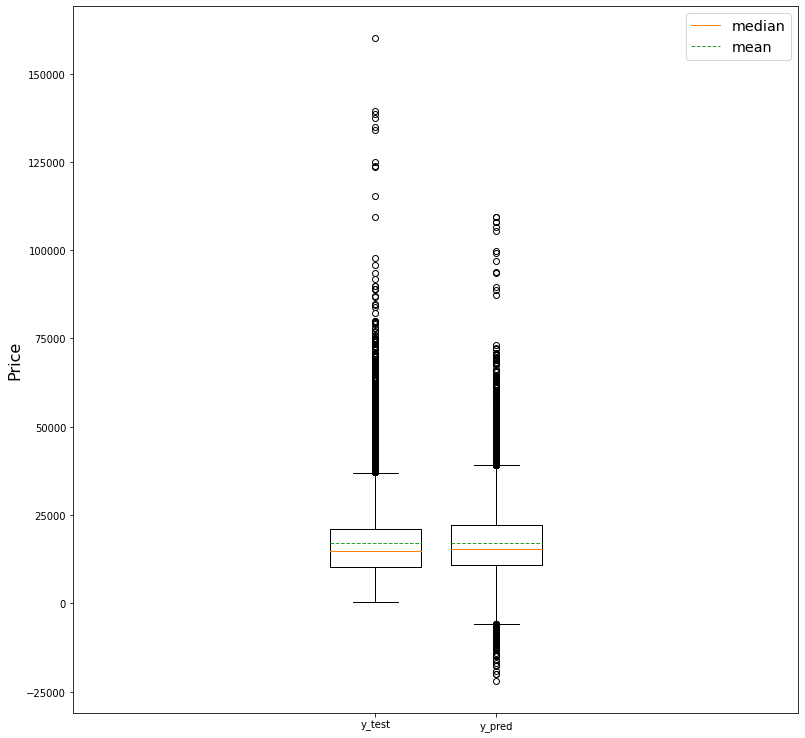

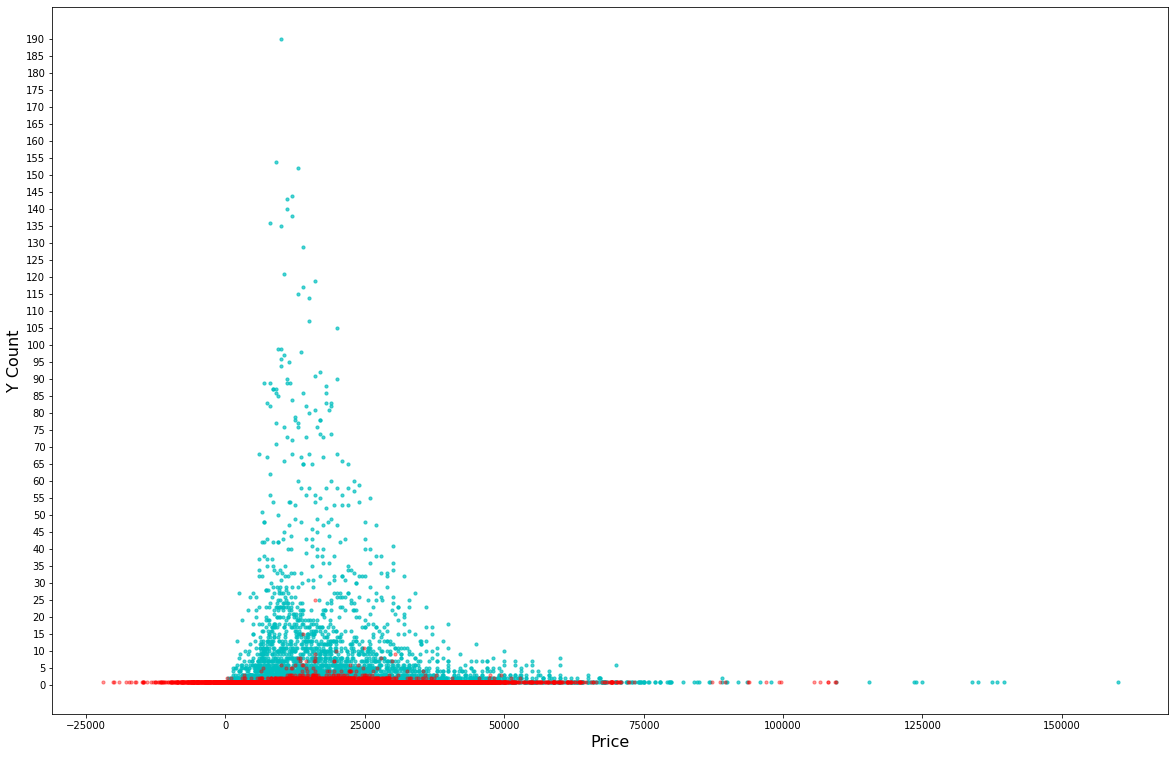

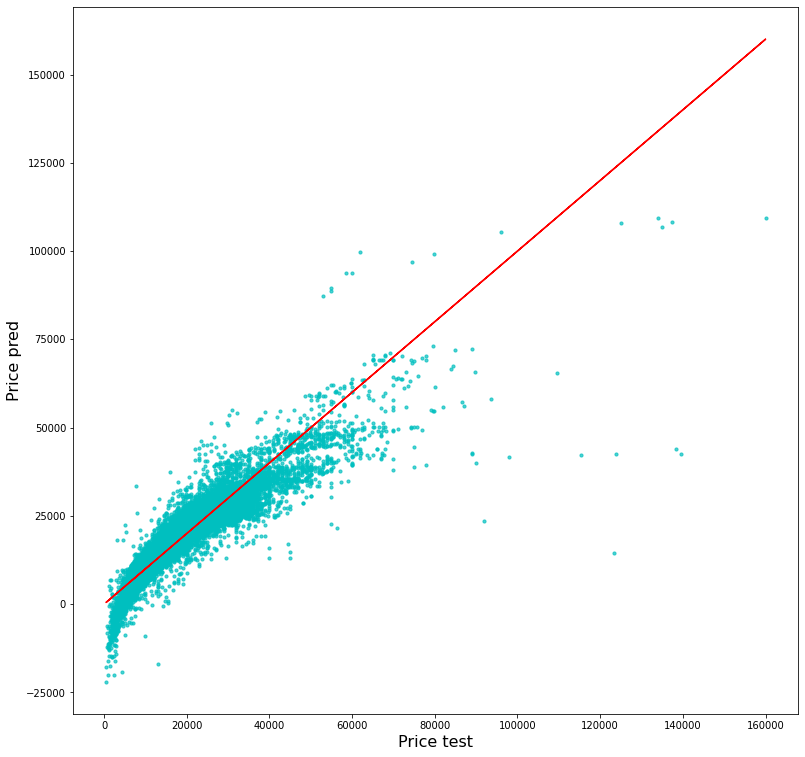

time: 940 ms (started: 2021-06-17 15:31:13 +00:00)


In [ ]:
print_results(y_test, y_pred)


## Regresión Lineal (Regularización)  


### Ridge  
En Ridge los hiperparametros con los cuales vamos a realizar el gridSearchCV son:  
* Parametro **alpha**
* Fit_Intercept

Esto nos ayudara a poder mejorar las predicciones de nuestro algoritmo ya que de esta manera nuestra regresion lineal estara mas adaptada a los valores dispares que puedan llegar a tener nuestras bases de datos.

Para saber que hiperparametros de alpha y de interceft son los mas adientes para nuestro modelo. Hemos utilizado las función de la libreria gridCV best_params_

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from  sklearn.model_selection import GridSearchCV

# Nos definimos el aram_grid con los parametros a optimizar Ridge
alpha_grid = np.arange(0,1, 0.05)
fit_grid = np.array([True, False])

parameters = {'alpha':alpha_grid, 'fit_intercept':fit_grid}

#Creamos y entrenamos el GridSearch
gridCV = GridSearchCV(Ridge(random_state=4815), parameters, cv=5, n_jobs = -1 )       
gridCV.fit(X_train, y_train)

best_alpha = gridCV.best_params_['alpha']
best_intercept = gridCV.best_params_['fit_intercept']

print("Best alpha [Ridge]: " + str(best_alpha))
print("Best fit_intercept [Ridge]: " + str(best_intercept))

Best alpha [Ridge]: 0.05
Best fit_intercept [Ridge]: True
time: 1min 23s (started: 2021-06-17 20:05:52 +00:00)


Best alpha [Ridge]: 0.1
Best fit_intercept [Ridge]: True

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from  sklearn.model_selection import GridSearchCV

# Creamos el objeto Ridge con los mejores parametros del GridSearchCV
ridge = Ridge(alpha = 0.05, fit_intercept = True)

# Entrenamos el modelo
ridge.fit(X_train, y_train)
print("Ridge Intercept: " + str(ridge.intercept_))
# print("Ridge Coef: " + str(ridge.coef_))

Ridge Intercept: [-45751.19186862]
time: 294 ms (started: 2021-06-17 20:07:36 +00:00)


Una vez realizada la regresion linear utilizando ridge, calculamos los diferentes errores:

In [ ]:
# Hacemos la prediccion
y_pred = ridge.predict(X_test)

# Mostramos las metricas de evaluacion
print("Metricas de evaluacion para Ridge:\n")
print("MAE: ",metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("R2: ", ridge.score(X_test, y_test))

Metricas de evaluacion para Ridge:

MAE:  2299.93078181883
MSE:  13856571.038270762
RMSE:  3722.441542626393
R2:  0.8563462904144101
time: 56.1 ms (started: 2021-06-17 20:07:43 +00:00)


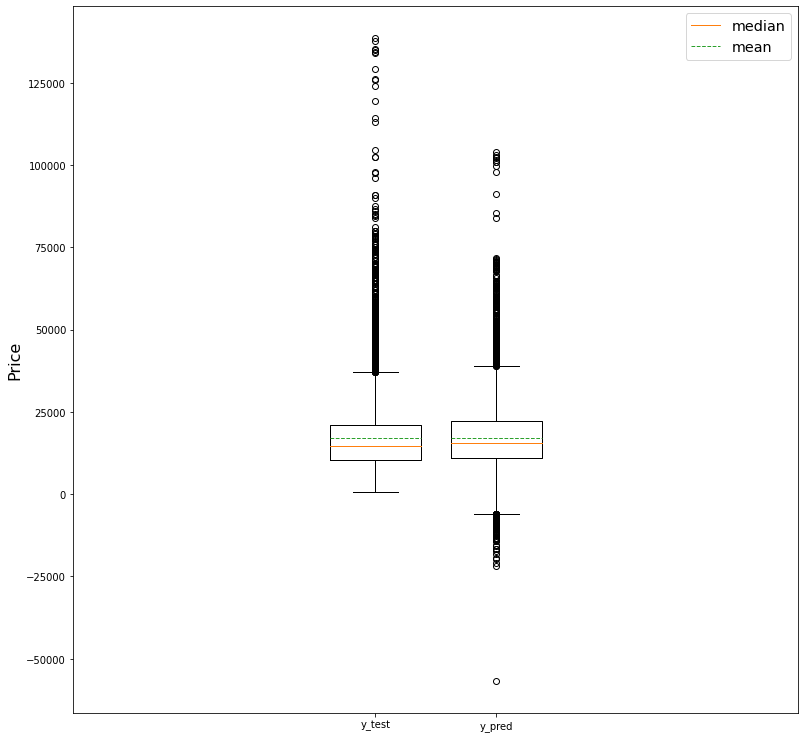

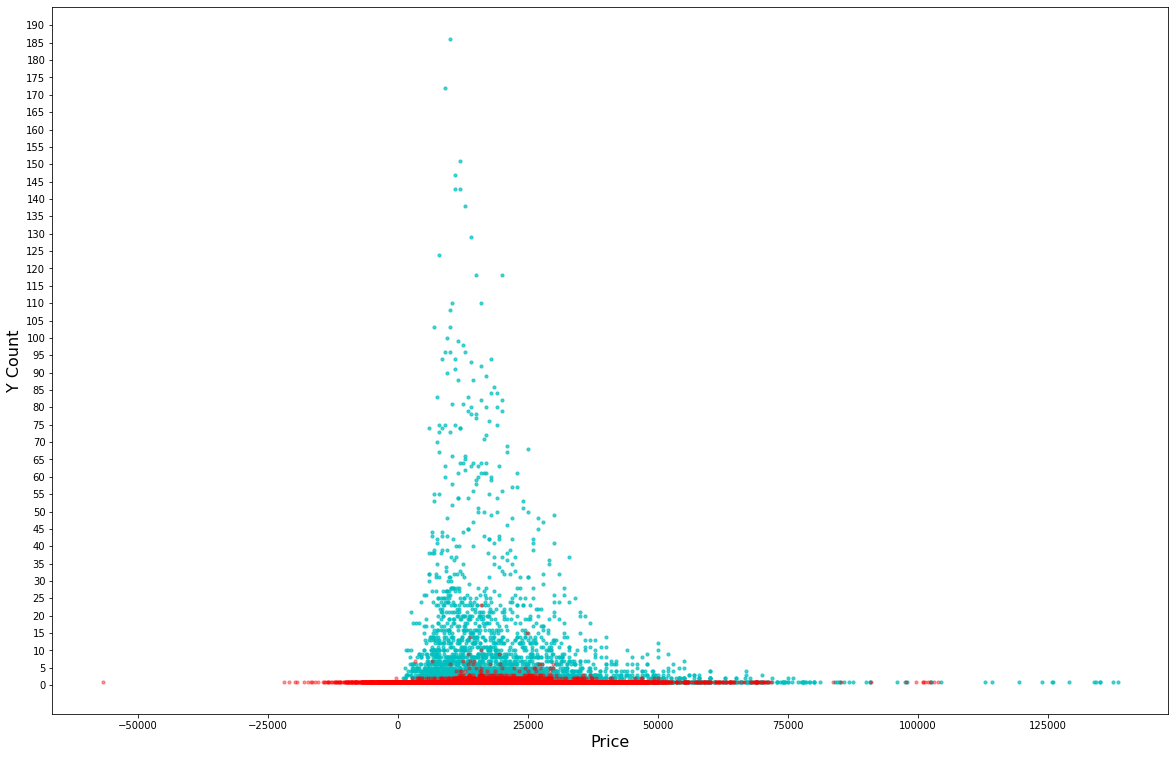

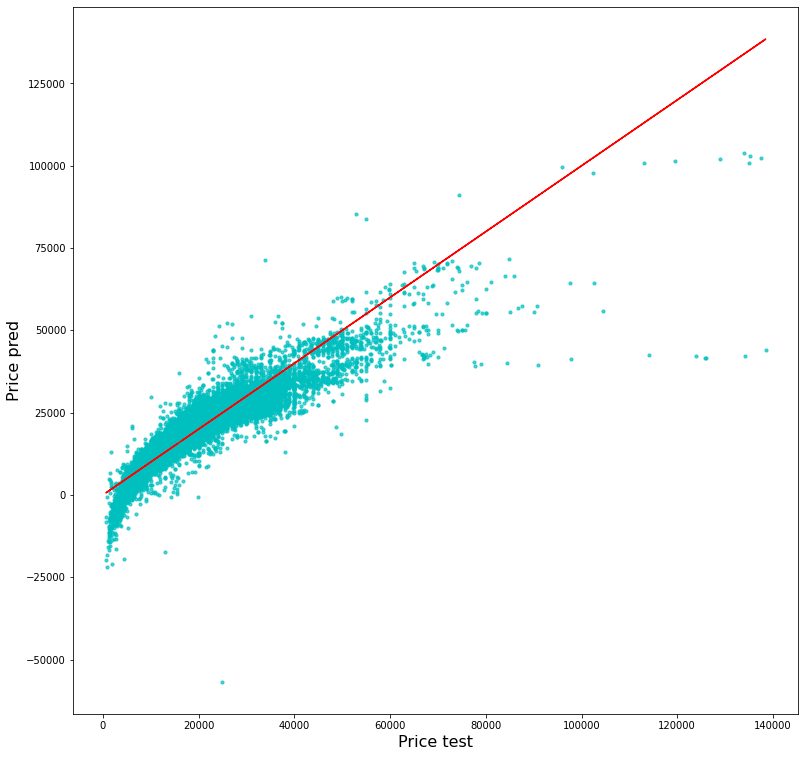

time: 1.05 s (started: 2021-06-17 20:10:06 +00:00)


In [ ]:
print_results(y_test, y_pred)


### Lasso
Al igual que en Ridge los parámetros que optimizaremos en Lasso son:  
* alpha 
* fit_intercept

In [ ]:
from  sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
# Nos definimos el param_grid con los parametros a optimizar de Lasso
alpha_grid = np.array([0.0001,0.001,0.01,0.1])
fit_grid = np.array([True, False])

parameters = {'alpha':alpha_grid,'fit_intercept':fit_grid}

#Creamos y entrenamos el GridSearch
gridCV = GridSearchCV(Lasso(), param_grid =  parameters,verbose = 2)       
gridCV.fit(X_train, y_train)

#Mostramos los mejores parametros
best_alpha = gridCV.best_params_['alpha']
# best_intercept = gridCV.best_params_['fit_intercept']
print("Best alpha [Lasso]: " + str(best_alpha))
# print("Best fit_intercept [Lasso]: " + str(best_intercept))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] alpha=0.0001, fit_intercept=True ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358218528863.70593, tolerance: 584453911.9595307
  positive)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s remaining:    0.0s


[CV] ................. alpha=0.0001, fit_intercept=True, total=  28.4s
[CV] alpha=0.0001, fit_intercept=True ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361649979457.8577, tolerance: 576028096.4905832
  positive)


[CV] ................. alpha=0.0001, fit_intercept=True, total=  29.3s
[CV] alpha=0.0001, fit_intercept=True ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361609489158.3849, tolerance: 570950025.3844477
  positive)


[CV] ................. alpha=0.0001, fit_intercept=True, total=  29.3s
[CV] alpha=0.0001, fit_intercept=True ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354931033591.44244, tolerance: 574507150.0533139
  positive)


[CV] ................. alpha=0.0001, fit_intercept=True, total=  29.0s
[CV] alpha=0.0001, fit_intercept=True ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337025155908.9363, tolerance: 570165116.935814
  positive)


[CV] ................. alpha=0.0001, fit_intercept=True, total=  28.8s
[CV] alpha=0.0001, fit_intercept=False ...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430356424021.3445, tolerance: 2321624393.8795
  positive)


[CV] ................ alpha=0.0001, fit_intercept=False, total=  21.1s
[CV] alpha=0.0001, fit_intercept=False ...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435782101221.39246, tolerance: 2306366744.4962
  positive)


[CV] ................ alpha=0.0001, fit_intercept=False, total=  20.6s
[CV] alpha=0.0001, fit_intercept=False ...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423351434714.8076, tolerance: 2299860182.567
  positive)


[CV] ................ alpha=0.0001, fit_intercept=False, total=  20.7s
[CV] alpha=0.0001, fit_intercept=False ...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 417672650765.53253, tolerance: 2303386100.7413
  positive)


[CV] ................ alpha=0.0001, fit_intercept=False, total=  20.3s
[CV] alpha=0.0001, fit_intercept=False ...............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412059089713.02155, tolerance: 2294815763.5384
  positive)


[CV] ................ alpha=0.0001, fit_intercept=False, total=  20.5s
[CV] alpha=0.001, fit_intercept=True .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354956039699.1288, tolerance: 584453911.9595307
  positive)


[CV] .................. alpha=0.001, fit_intercept=True, total=  29.8s
[CV] alpha=0.001, fit_intercept=True .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358358151290.34546, tolerance: 576028096.4905832
  positive)


[CV] .................. alpha=0.001, fit_intercept=True, total=  29.5s
[CV] alpha=0.001, fit_intercept=True .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359395832587.82153, tolerance: 570950025.3844477
  positive)


[CV] .................. alpha=0.001, fit_intercept=True, total=  29.3s
[CV] alpha=0.001, fit_intercept=True .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347700122217.32996, tolerance: 574507150.0533139
  positive)


[CV] .................. alpha=0.001, fit_intercept=True, total=  28.9s
[CV] alpha=0.001, fit_intercept=True .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336799926307.94025, tolerance: 570165116.935814
  positive)


[CV] .................. alpha=0.001, fit_intercept=True, total=  29.0s
[CV] alpha=0.001, fit_intercept=False ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430443535548.4663, tolerance: 2321624393.8795
  positive)


[CV] ................. alpha=0.001, fit_intercept=False, total=  21.3s
[CV] alpha=0.001, fit_intercept=False ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435862435398.5299, tolerance: 2306366744.4962
  positive)


[CV] ................. alpha=0.001, fit_intercept=False, total=  20.9s
[CV] alpha=0.001, fit_intercept=False ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423434756058.4418, tolerance: 2299860182.567
  positive)


[CV] ................. alpha=0.001, fit_intercept=False, total=  21.4s
[CV] alpha=0.001, fit_intercept=False ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 417757843903.4184, tolerance: 2303386100.7413
  positive)


[CV] ................. alpha=0.001, fit_intercept=False, total=  21.2s
[CV] alpha=0.001, fit_intercept=False ................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412137313649.40295, tolerance: 2294815763.5384
  positive)


[CV] ................. alpha=0.001, fit_intercept=False, total=  21.1s
[CV] alpha=0.01, fit_intercept=True ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330028202371.23157, tolerance: 584453911.9595307
  positive)


[CV] ................... alpha=0.01, fit_intercept=True, total=  29.3s
[CV] alpha=0.01, fit_intercept=True ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321886488861.0586, tolerance: 576028096.4905832
  positive)


[CV] ................... alpha=0.01, fit_intercept=True, total=  28.8s
[CV] alpha=0.01, fit_intercept=True ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322703759007.6429, tolerance: 570950025.3844477
  positive)


[CV] ................... alpha=0.01, fit_intercept=True, total=  29.0s
[CV] alpha=0.01, fit_intercept=True ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 389641726650.86725, tolerance: 574507150.0533139
  positive)


[CV] ................... alpha=0.01, fit_intercept=True, total=  28.7s
[CV] alpha=0.01, fit_intercept=True ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310623463246.69727, tolerance: 570165116.935814
  positive)


[CV] ................... alpha=0.01, fit_intercept=True, total=  28.5s
[CV] alpha=0.01, fit_intercept=False .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431342399376.3225, tolerance: 2321624393.8795
  positive)


[CV] .................. alpha=0.01, fit_intercept=False, total=  21.7s
[CV] alpha=0.01, fit_intercept=False .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436717483051.32904, tolerance: 2306366744.4962
  positive)


[CV] .................. alpha=0.01, fit_intercept=False, total=  21.3s
[CV] alpha=0.01, fit_intercept=False .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424313453703.31647, tolerance: 2299860182.567
  positive)


[CV] .................. alpha=0.01, fit_intercept=False, total=  21.2s
[CV] alpha=0.01, fit_intercept=False .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418652717815.2412, tolerance: 2303386100.7413
  positive)


[CV] .................. alpha=0.01, fit_intercept=False, total=  20.9s
[CV] alpha=0.01, fit_intercept=False .................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412979653494.3675, tolerance: 2294815763.5384
  positive)


[CV] .................. alpha=0.01, fit_intercept=False, total=  20.9s
[CV] alpha=0.1, fit_intercept=True ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219403944484.94806, tolerance: 584453911.9595307
  positive)


[CV] .................... alpha=0.1, fit_intercept=True, total=  26.8s
[CV] alpha=0.1, fit_intercept=True ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152757528855.92517, tolerance: 576028096.4905832
  positive)


[CV] .................... alpha=0.1, fit_intercept=True, total=  27.0s
[CV] alpha=0.1, fit_intercept=True ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198667734879.95517, tolerance: 570950025.3844477
  positive)


[CV] .................... alpha=0.1, fit_intercept=True, total=  26.5s
[CV] alpha=0.1, fit_intercept=True ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172768243413.28766, tolerance: 574507150.0533139
  positive)


[CV] .................... alpha=0.1, fit_intercept=True, total=  26.2s
[CV] alpha=0.1, fit_intercept=True ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166111120194.63257, tolerance: 570165116.935814
  positive)


[CV] .................... alpha=0.1, fit_intercept=True, total=  27.2s
[CV] alpha=0.1, fit_intercept=False ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441234952477.0117, tolerance: 2321624393.8795
  positive)


[CV] ................... alpha=0.1, fit_intercept=False, total=  19.4s
[CV] alpha=0.1, fit_intercept=False ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 446451330063.70306, tolerance: 2306366744.4962
  positive)


[CV] ................... alpha=0.1, fit_intercept=False, total=  19.4s
[CV] alpha=0.1, fit_intercept=False ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433986634871.47534, tolerance: 2299860182.567
  positive)


[CV] ................... alpha=0.1, fit_intercept=False, total=  19.3s
[CV] alpha=0.1, fit_intercept=False ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428406346914.89233, tolerance: 2303386100.7413
  positive)


[CV] ................... alpha=0.1, fit_intercept=False, total=  18.9s
[CV] alpha=0.1, fit_intercept=False ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422736758149.48975, tolerance: 2294815763.5384
  positive)
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 16.3min finished


[CV] ................... alpha=0.1, fit_intercept=False, total=  18.8s
Best alpha [Lasso]: 0.01
time: 17min 2s (started: 2021-06-18 13:12:48 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456867406572.50275, tolerance: 719029070.0293636
  positive)


In [ ]:
# Creamos la instancia de Lasso usando los mejores parámetros.
lasso = Lasso(alpha=0.01, fit_intercept = True)

#Entrenamos el modelo
lasso.fit(X_train, y_train)
print("Lasso Intercept: " + str(lasso.intercept_))
# print("Lasso Coef: " + str(lasso.coef_))

Lasso Intercept: [-53646.49492226]
time: 41.9 s (started: 2021-06-18 13:31:36 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456867406572.50275, tolerance: 719029070.0293636
  positive)


In [ ]:
# Hacemos la prediccion
y_pred = lasso.predict(X_test)

# Mostramos las metricas de evaluacion
print("Metricas de evaluacion para Lasso:\n")
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))

Metricas de evaluacion para Lasso:

MAE:  2299.9743865262903
MSE:  13857147.278039226
RMSE:  3722.5189426031434
time: 38.8 ms (started: 2021-06-18 13:32:21 +00:00)


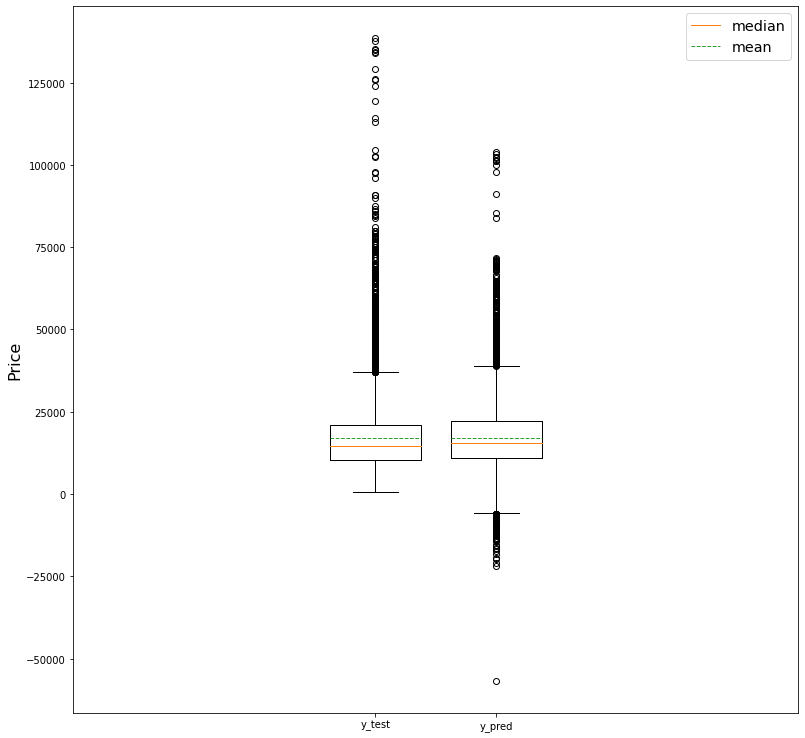

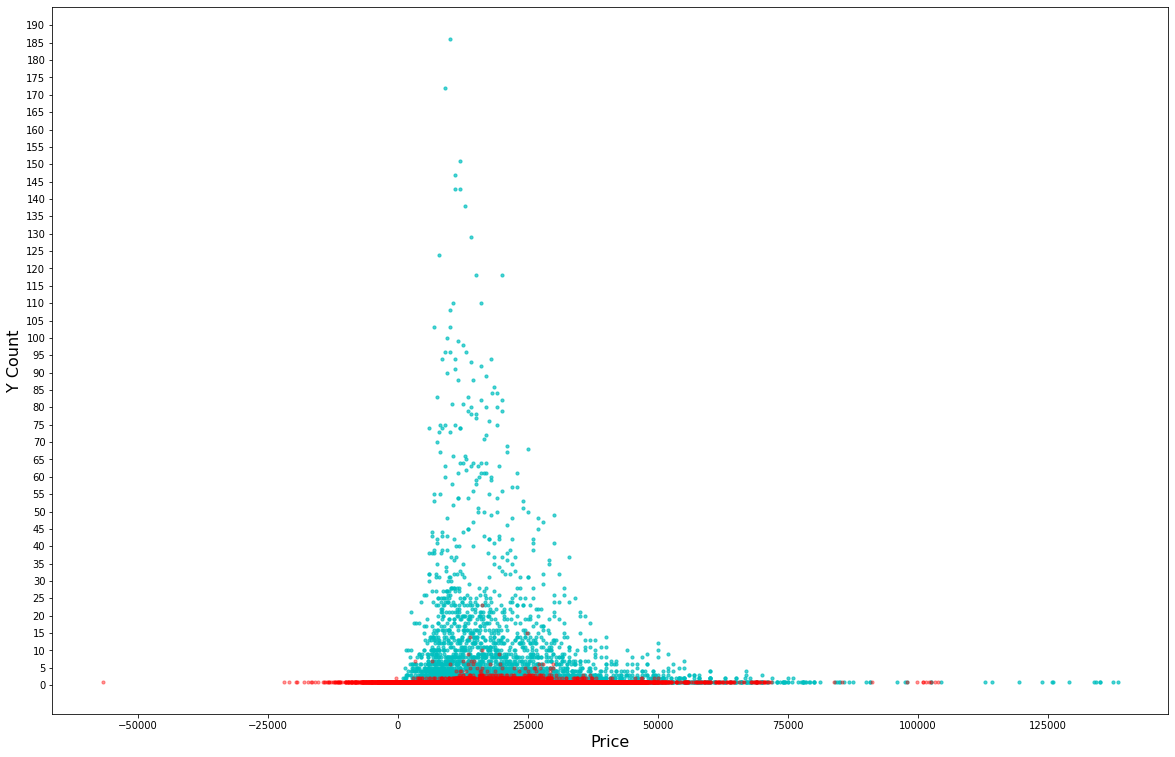

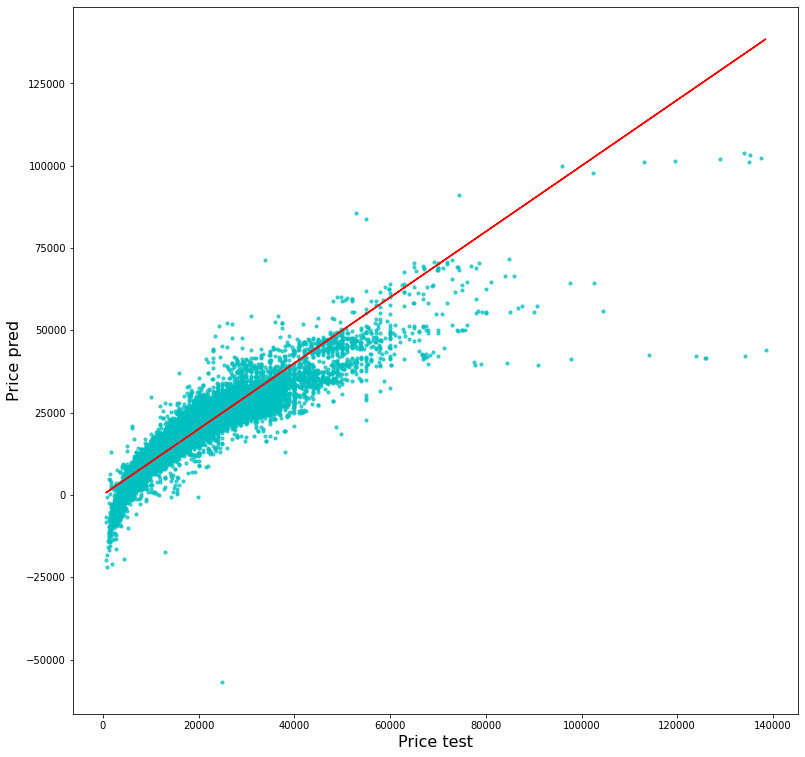

time: 1.01 s (started: 2021-06-18 13:32:53 +00:00)


In [ ]:
print_results(y_test, y_pred)


### **ElasticNet** Alpha
   *   **Ridge** Valor 0 a r (l1_ratio)
   *   **Lasso** Valor 1 a r (l1_ratio)

In [ ]:
from sklearn.linear_model import ElasticNet
from  sklearn.model_selection import GridSearchCV

# Elegimos los parametros del Grid para ElasticNet
r_grid = np.arange(0.0,1.0,0.1)
alpha_grid = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
max_iter_grid = [1, 5, 10]

parameters = {'l1_ratio': r_grid, 'alpha': alpha_grid, "max_iter": max_iter_grid}

# Entrenamos el GridSearchCV 
gridCV = GridSearchCV(ElasticNet(random_state = 4815), parameters, cv=10, n_jobs = -1) 
gridCV.fit(X_train, y_train)

# Mostramos los mejores parametros
best_r = gridCV.best_params_['l1_ratio']
best_alpha = gridCV.best_params_['alpha']
best_max_iter = gridCV.best_params_['max_iter']
print("Best r for ElasticNet : " + str(best_r))
print("Best alpha for ElasticNet : " + str(best_alpha))
print("Best max_iter for ElasticNet : " + str(best_max_iter))

Best r for ElasticNet : 0.9
Best alpha for ElasticNet : 0.0001
Best max_iter for ElasticNet : 10
time: 11min 4s (started: 2021-06-16 14:55:42 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523766185869.62604, tolerance: 722096637.5028635
  positive)


Best r for ElasticNet : 0.9
Best alpha for ElasticNet : 0.0001
Best max_iter for ElasticNet : 10

In [ ]:
from sklearn.linear_model import ElasticNet

# Creamos una instancia de ElasticNet usando los mejores parametros
elastic = ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter = 10)

# Entrenamos el modelo
elastic.fit(X_train, y_train)
print("Elastic Intercept: " + str(elastic.intercept_))
# print("Elastic Coef: " + str(elastic.coef_))

Elastic Intercept: [-53369.79527305]
time: 502 ms (started: 2021-06-17 15:36:06 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523762451066.5025, tolerance: 718936685.0098401
  positive)


In [ ]:
# Hacemos la prediccion
y_pred = elastic.predict(X_test)

# Mostramos las metricas de evaluacion
print("Metricas de evaluacion para ElasticNet:\n")
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("R2: ", elastic.score(X_test, y_test))

Metricas de evaluacion para ElasticNet:

MAE:  2302.391867580367
MSE:  13930328.465134481
RMSE:  3732.335524190514
R2:  0.8556011217012721
time: 54.6 ms (started: 2021-06-17 15:36:08 +00:00)


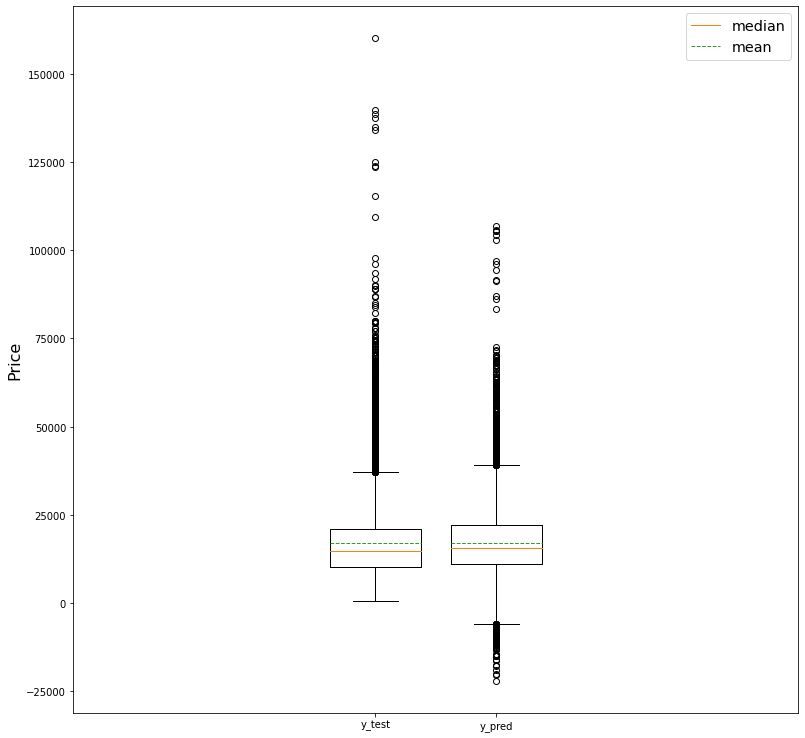

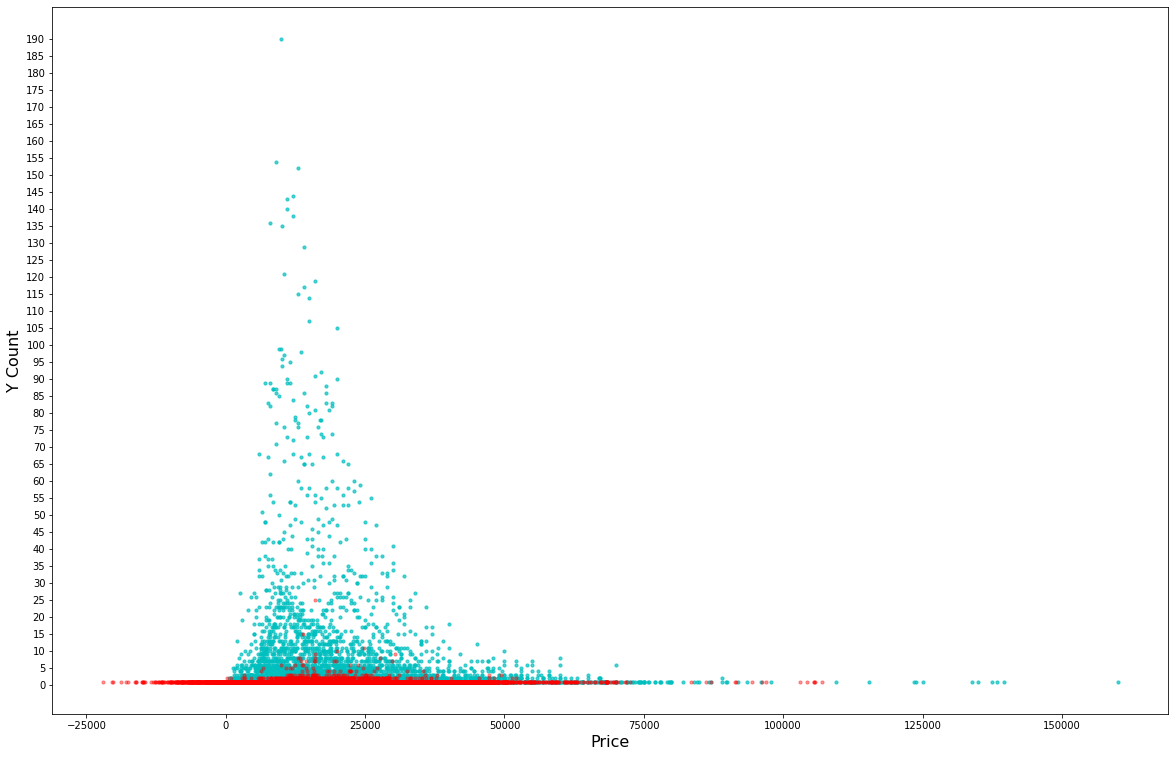

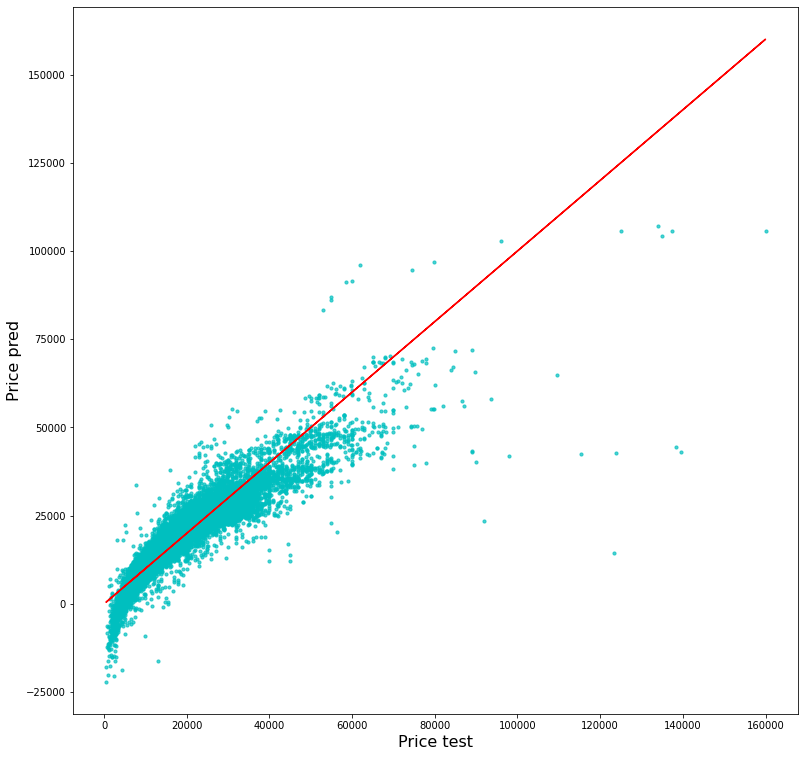

time: 932 ms (started: 2021-06-17 15:36:09 +00:00)


In [ ]:
print_results(y_test, y_pred)


## Regresión Polinómica
Para hacer regresión polinómica debemos aumentar las features usando la funcion PolinomialFeatures, el problema es que si lo aplicamos al dataset con las variables categóricas, el número de variables se va de las manos. Por ello hacemos:
* 1. Extraemos aquellas variables a las que no se les ha hecho el oneHotEncoding.
* 2. Aplicamos PolynomialFeatures a esta parte de los datos.
* 3. Unimos las nuevas columnas a las del OneHotEncoding.
* 4. Procesamos la regresión Lineal.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

df_simple_train = X_train[['year','mileage','tax','mpg','engineSize']]
df_simple_test = X_test[['year','mileage','tax','mpg','engineSize']]


poly_X_train = PolynomialFeatures(degree=4, include_bias=False).fit_transform(df_simple_train) 
poly_X_test = PolynomialFeatures(degree=4, include_bias=False).fit_transform(df_simple_test)

# Juntamos con el resto de columnas
poly_X_train = np.concatenate([poly_X_train,X_train.drop(columns = ['year','mileage','tax','mpg','engineSize'])],axis = 1)
poly_X_test = np.concatenate([poly_X_test,X_test.drop(columns = ['year','mileage','tax','mpg','engineSize'])],axis = 1)

# Creamos un objeto de regresion lineal
poly_reg = LinearRegression()

# Entrenamos
poly_reg.fit(poly_X_train, y_train)
print("Linear Regresion Intercept: " + str(poly_reg.intercept_))
# print("Linear Regresion Coef: " + str(poly_reg.coef_))

y_pred = poly_reg.predict(poly_X_test)

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
print("R2: ", poly_reg.score(poly_X_test, y_test))

Linear Regresion Intercept: [182111.76375111]
MAE:  1756.331326035101
MSE:  8486052.275979409
RMSE:  2913.0829504117128
R2:  0.9120353527267698
time: 2.65 s (started: 2021-06-17 15:36:55 +00:00)


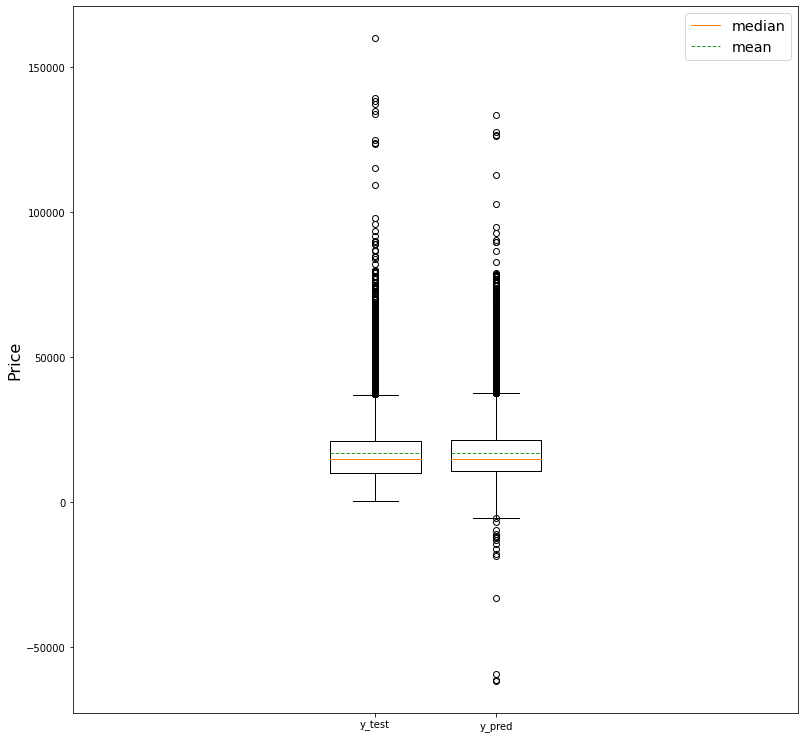

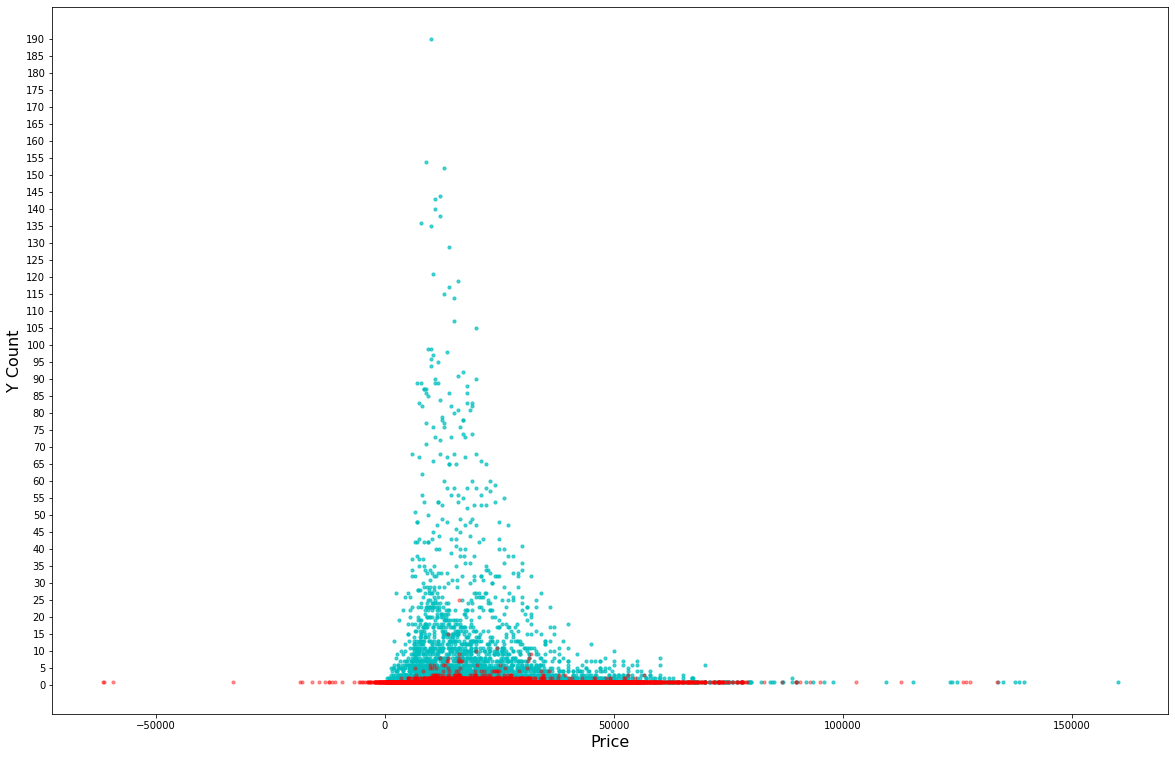

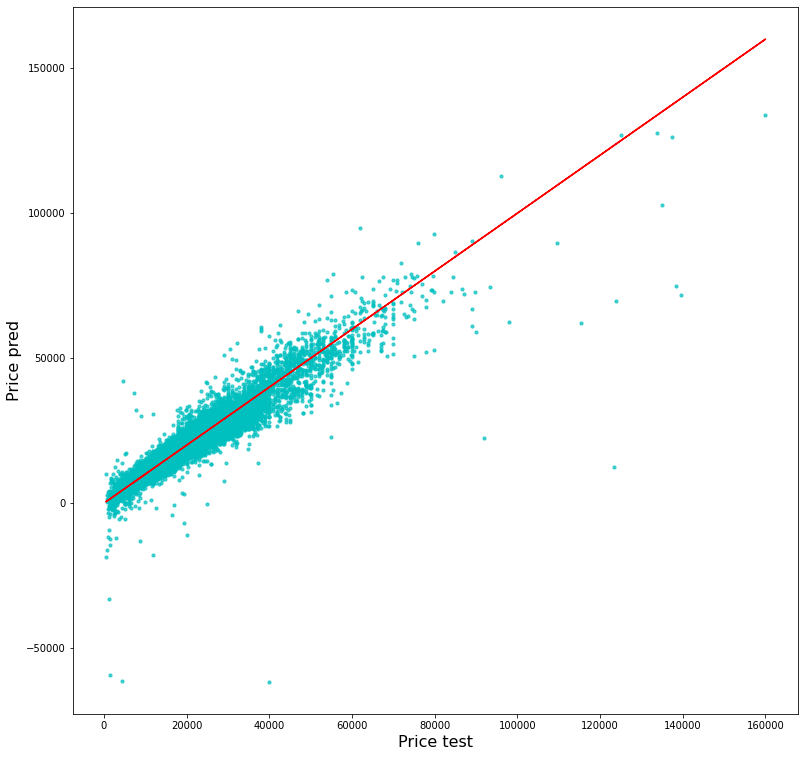

time: 910 ms (started: 2021-06-17 15:37:01 +00:00)


In [ ]:
print_results(y_test, y_pred)


## SGD  
Intentamos mejorar:  
* penalty
* regularizacion
* alpha
* fit_intercept poner a True


In [ ]:
from sklearn.linear_model import SGDRegressor
from  sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Creamos el grid con los parametros para el GridSearchCV
param_grid = {'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling']
   # 'max_iter': [10,100,1000,5000]
}

scaler = StandardScaler()
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)

gridCV = GridSearchCV(SGDRegressor(), param_grid = param_grid)
gridCV.fit(X_train_, y_train.ravel())

# Mostramos los mejores parámetros
best_alpha = gridCV.best_params_['alpha']
best_max_iter = gridCV.best_params_['max_iter']
best_penalty = gridCV.best_params_['penalty']
best_learning_rate = gridCV.best_params_['learning_rate']
best_loss = gridCV.best_params_['loss']

print("Best alpha for SGDRegressor: " + str(best_alpha))
print("Best penalty for SGDRegressor: " + str(best_penalty))
print("Best learning_rate for SGDRegressor: " + str(best_learning_rate))
print("Best loss for SGDRegressor: " + str(best_loss))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linea

In [ ]:
from sklearn.linear_model import SGDRegressor

scaler = StandardScaler()
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)

sgd = SGDRegressor(random_state=4815).fit(X_train_, y_train.ravel())
print("SGD Intercept: " + str(sgd.intercept_))
# print("SGD Coef: " + str(sgd.coef_))
y_pred = sgd.predict(X_test_)

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
# print("R2: ", poly.score(X_test, y_test))

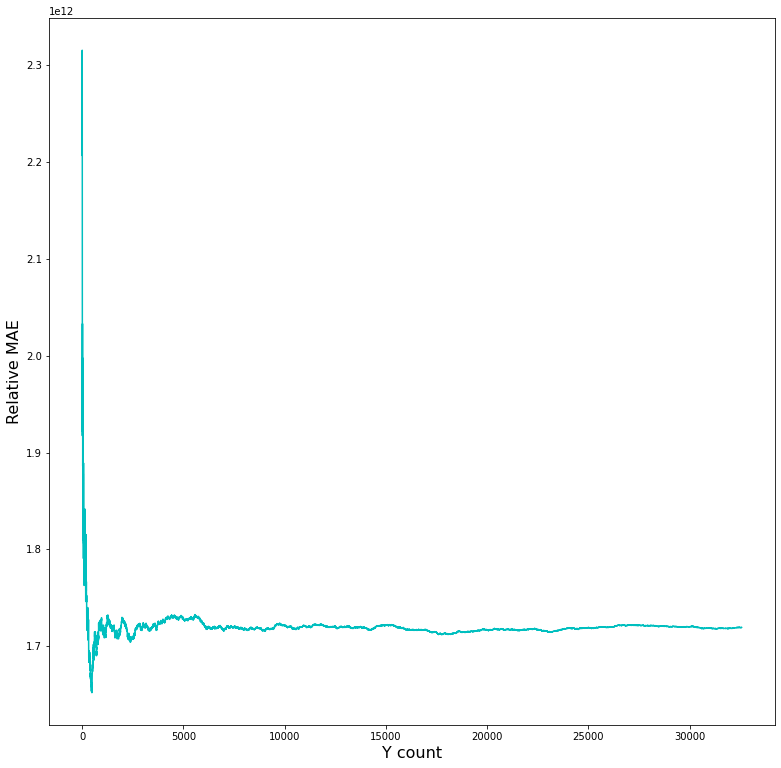

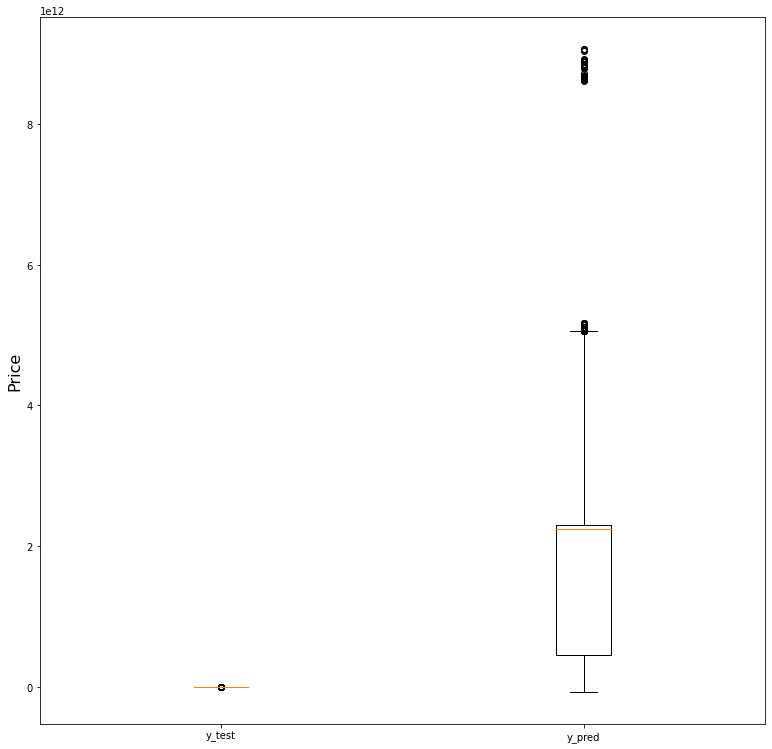

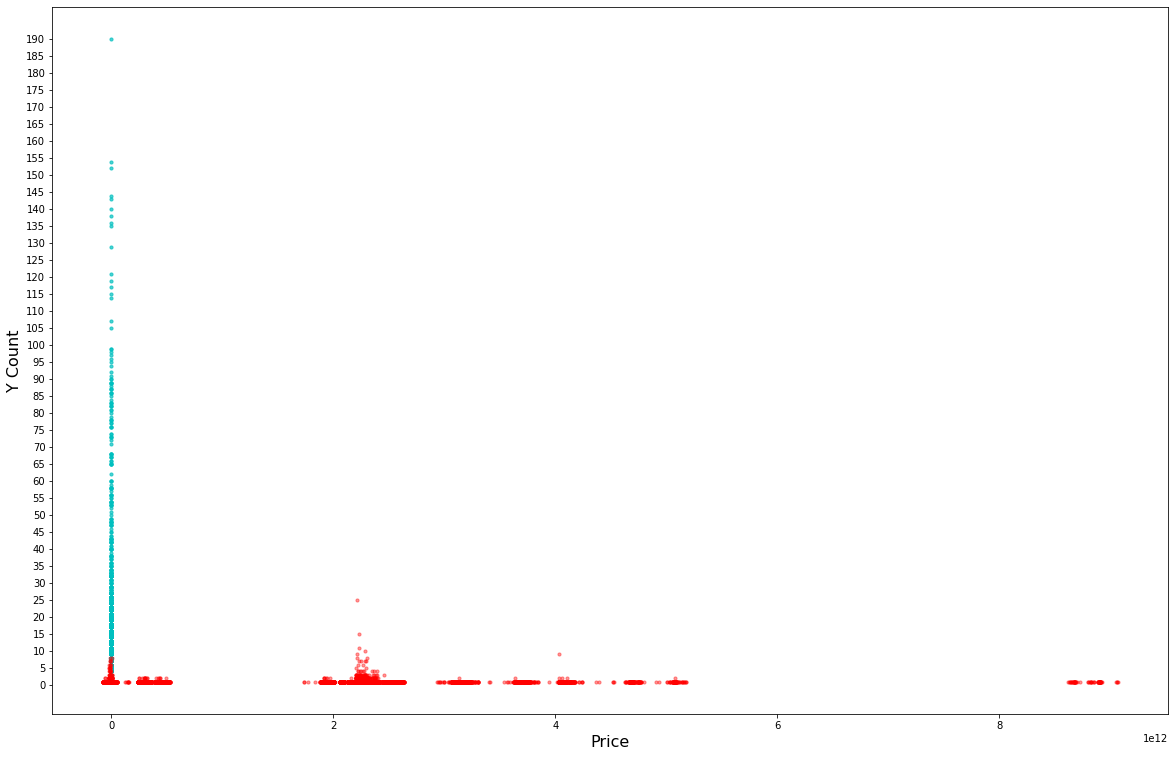

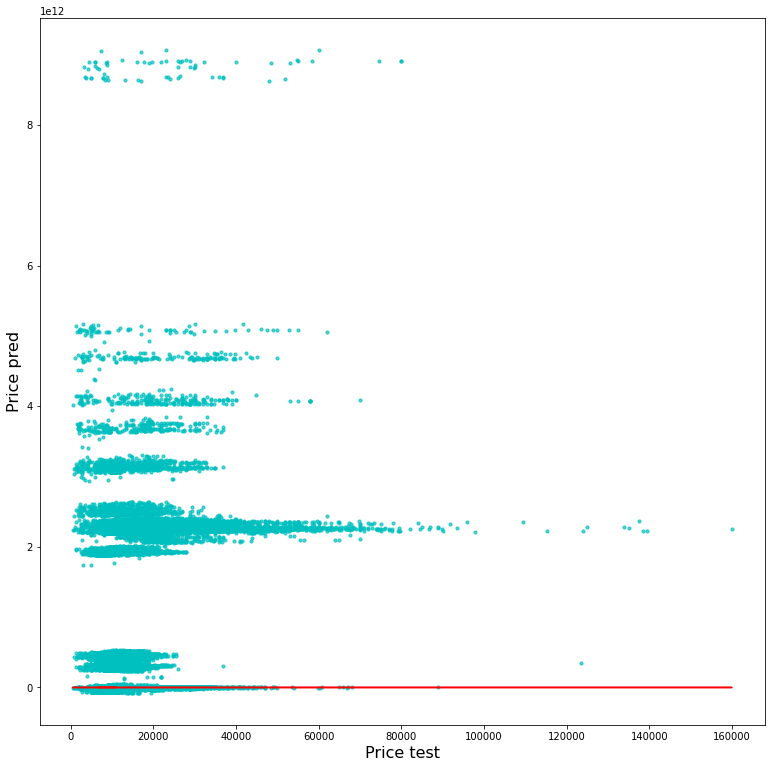

time: 1.34 s (started: 2021-06-16 20:58:54 +00:00)


In [ ]:
print_results(y_test, y_pred)


## RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from  sklearn.model_selection import GridSearchCV

n_est_grid = np.array([1,10,100])
crit_grid = np.array(['mse','mae'])
max_depth_grid = np.array([None,10])

parameters = {'n_estimators': n_est_grid,'criterion':crit_grid,'max_depth':max_depth_grid}


gridCV = GridSearchCV(RandomForestRegressor(random_state = 4815),param_grid=parameters,cv = 5,verbose = 3.5)
gridCV.fit(X_train,y_train)

best_n_estimators = gridCV.best_params_['n_estimators']
best_criterion = gridCV.best_params_['criterion']
best_max_depth = gridCV.best_params_['max_depth']

print("Best n_estimators: " + str(best_n_estimators))
print("Best criterion: " + str(best_criterion))
print("Best max_depth: " + str(best_max_depth))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] max_depth=None, n_estimators=1 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=None, n_estimators=1, score=0.919, total= 3.9min
[CV] max_depth=None, n_estimators=1 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Implementamos un randomForest
rf_reg = RandomForestRegressor(n_estimators=10,random_state = 4815)
rf_reg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=4815, verbose=0, warm_start=False)

time: 12.7 s (started: 2021-06-17 21:40:01 +00:00)


In [ ]:
#Mostramos los resultados del Randomforest
y_pred = rf_reg.predict(X_test)

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("R2: ", rf_reg.score(X_test, y_test))

MAE:  1212.3593695661546
MSE:  4005126.8575638253
RMSE:  2001.2813039559994
R2:  0.9584780874820441
time: 701 ms (started: 2021-06-17 21:41:07 +00:00)


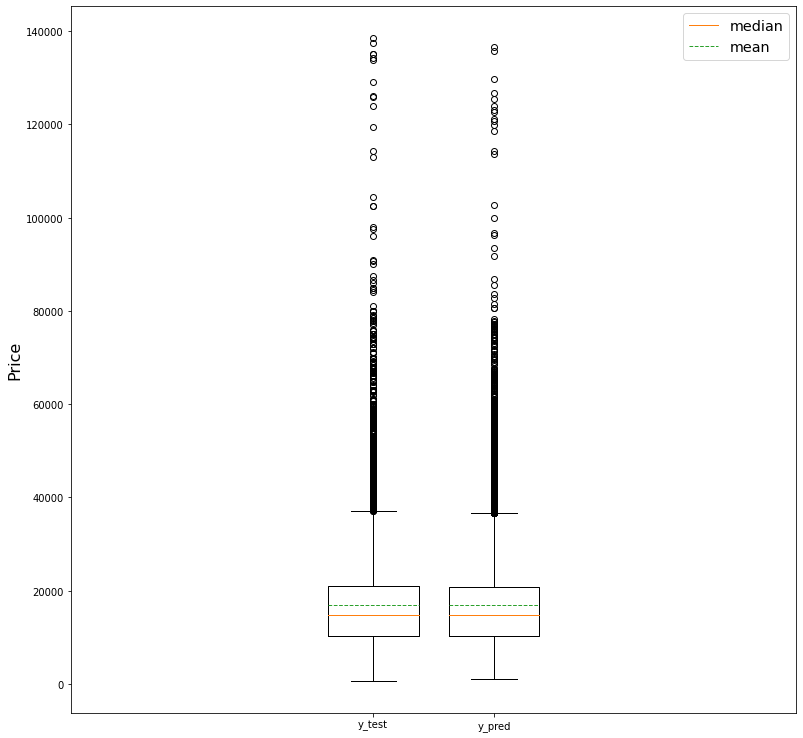

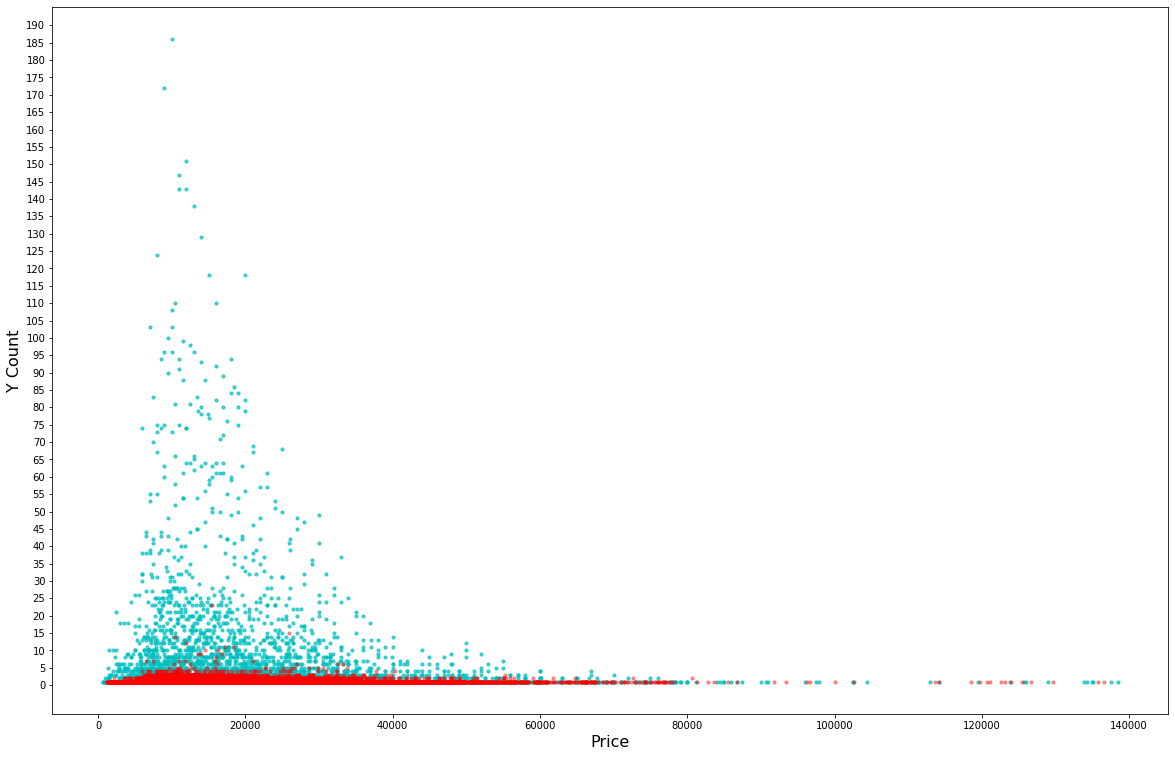

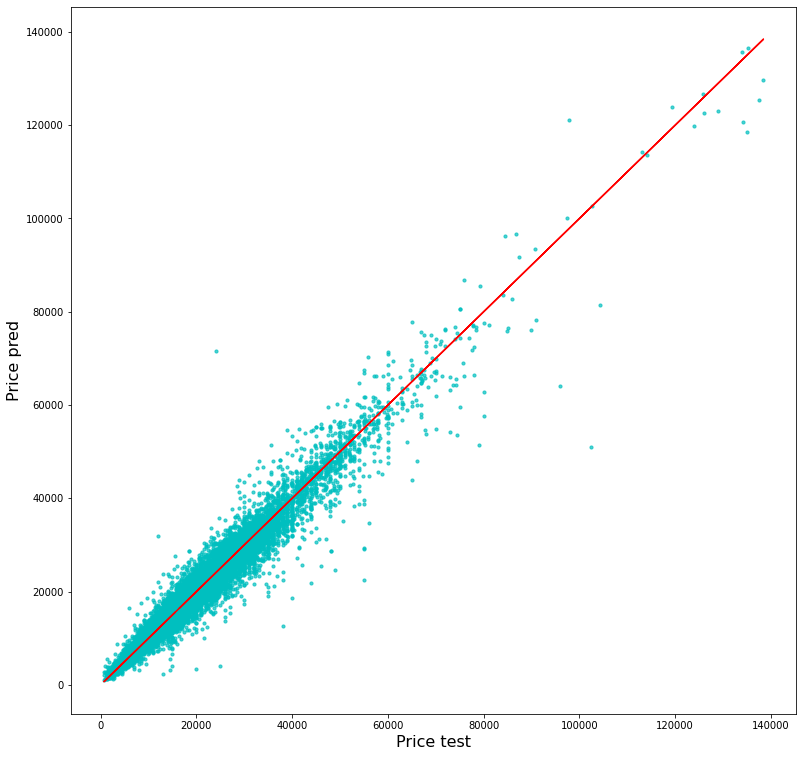

time: 989 ms (started: 2021-06-17 21:42:36 +00:00)


In [ ]:
print_results(y_test, y_pred)

# Deep Learning

## Definición del modelo

In [ ]:
def createDenseNetwork(n_layers=1, n_neurons_l1=32, n_neurons_l2=32, n_neurons_l3=16,
                       activation_hiddden='relu', activation_output='relu', dropout=0):
    input_data = Input(shape=(X.shape[1]))

    if activation_hiddden == 'leakyrelu':
        x = Dense(n_neurons_l1)(input_data)
        x = LeakyReLU()(x)
    else:
        x = Dense(n_neurons_l1, activation=activation_hiddden)(input_data)

    x = Dropout(dropout)(x)

    if n_layers>=2:

        if activation_hiddden == 'leakyrelu':
            x = Dense(n_neurons_l2)(x)
            x = LeakyReLU()(x)
        else:
            x = Dense(n_neurons_l2, activation=activation_hiddden)(x)

            x = Dropout(dropout)(x)

    if n_layers>=3:
        for i in range(3, n_layers+1):
            # El número de neuronas de las siguientes capas es el mismo que el de la ultima capa

            if activation_hiddden == 'leakyrelu':
                x = Dense(n_neurons_l3)(x)
                x = LeakyReLU()(x)
            else:
                x = Dense(n_neurons_l3, activation=activation_hiddden)(x)

            x = Dropout(dropout)(x)

    if activation_output == 'leakyrelu':
        output_reg = Dense(1)(x)
        x = LeakyReLU()(x)
    else:
        output_reg = Dense(1, activation=activation_output)(x)
        
    return Model(input_data, output_reg)

time: 32.4 ms (started: 2021-06-17 20:24:28 +00:00)


In [ ]:
def createModel(n_layers=1, n_neurons_l1=32, n_neurons_l2=32, n_neurons_l3=16,
                activation_hiddden='relu', activation_output='relu', dropout=0,
                optimizer='adam', n_epochs=1,
                x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test):
    
    model = createDenseNetwork(n_layers=1, n_neurons_l1=32, n_neurons_l2=32, n_neurons_l3=16,
                               activation_hiddden='relu', activation_output='relu', dropout=0)
    
    if optimizer != 'RMSprop':
        model.compile(
        loss = 'mse',
        optimizer = optimizer,
        metrics=['accuracy']
        )

    else:
        model.compile(
            loss = 'mse',
            optimizer = RMSprop(),
            metrics=['accuracy']
        )

    history = model.fit(x_train, y_train,
                        batch_size=256,
                        epochs=n_epochs,
                        verbose=0,
                        validation_data=(x_test, y_test))
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: ' +  str(score[0]))
    
    return float(score[0])    # el valor de 'fitness' será el valor de evaluación de la función de coste

time: 22.1 ms (started: 2021-06-17 20:24:35 +00:00)


## Optimización de hiperparámetros (NeverGrad)

In [ ]:
!pip install nevergrad
import nevergrad as ng

     |████████████████████████████████| 389kB 7.1MB/s 
     |████████████████████████████████| 235kB 33.8MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=40a672088e0e0030fa8917a99d1e04062361983591ee0d5894761d86e7c3abd8
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization
time: 6.71 s (started: 2021-06-17 20:24:40 +00:00)


In [ ]:
layer_1 = ng.p.TransitionChoice(range(5, 100, 10))
layer_2 = ng.p.TransitionChoice(range(5, 100, 10))
layer_3 = ng.p.TransitionChoice(range(5, 100, 10))
n_layers = ng.p.TransitionChoice(range(1, 4, 1))
activation_output = ng.p.Choice(['relu', 'tanh', 'sigmoid', 'leakyrelu'])
activation_hiddden = ng.p.Choice(['relu', 'tanh', 'sigmoid', 'leakyrelu'])
optimizer = ng.p.Choice(['adam', 'SGD', 'RMSprop'])
n_epochs = ng.p.TransitionChoice(range(1, 20, 2))
dropout = ng.p.Scalar(lower=0, upper=1)

params = ng.p.Instrumentation(n_layers, layer_1, layer_2, layer_3, activation_hiddden, activation_output, dropout, optimizer, n_epochs)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=60)
best = optimizer.minimize(createModel, batch_mode=False)

print(best.value)

Test loss: 372276896.0
Test loss: 383269120.0
Test loss: 130522288.0
Test loss: 129255216.0
Test loss: 131966272.0
Test loss: 127828192.0
Test loss: 383269120.0
Test loss: 318152192.0
Test loss: 129848192.0
Test loss: 157527504.0
Test loss: 383269120.0
Test loss: 133470136.0
Test loss: 260868624.0
Test loss: 383269120.0
Test loss: 383269120.0
Test loss: 128181376.0
Test loss: 383269120.0
Test loss: 373723680.0
Test loss: 131308080.0
Test loss: 149962032.0
Test loss: 383269120.0
Test loss: 134400896.0
Test loss: 245070976.0
Test loss: 129839280.0
Test loss: 130491480.0
Test loss: 130282840.0
Test loss: 377344768.0
Test loss: 132299152.0
Test loss: 383269120.0
Test loss: 229718608.0
Test loss: 331696672.0
Test loss: 156838464.0
Test loss: 383269120.0
Test loss: 129673096.0
Test loss: 126470520.0
Test loss: 126322256.0
Test loss: 383269120.0
Test loss: 126772096.0
Test loss: 125029272.0
Test loss: 203664400.0
Test loss: 383269120.0
Test loss: 133360144.0
Test loss: 134332176.0
Test loss: 

## Evaluación del modelo
Se crea y entrena un modelo con los hiperparámetros encontrados

*   **Neuronas Capa 1:** 45
*   **Neuronas Capa 2:** 65
*   **Neuronas Capa 3:** 95
*   **Número de capas:** 3
*   **Activación capas ocultas:** ReLU
*   **Activación capa de salida:** LeakyReLU
*   **Dropout:** 10%
*   **Optimizador:** RMSprop
*   **Número de epochs:** 19

In [ ]:
model = createDenseNetwork(n_layers=3, n_neurons_l1=45, n_neurons_l2=65, n_neurons_l3=95,
                   activation_hiddden='relu', activation_output='leakyrelu', dropout=0.1)

model.compile(
              loss = 'mse',
              optimizer = 'RMSprop',
              metrics=['accuracy']
)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=19,
                    verbose=0,
                    validation_data=(X_test, y_test))

time: 24.5 s (started: 2021-06-17 20:40:35 +00:00)


In [ ]:
y_pred = model.predict(X_test)

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))

MAE:  2239.808137365908
MSE:  13295002.085696124
RMSE:  3646.2312167080304
time: 1.01 s (started: 2021-06-17 20:41:49 +00:00)


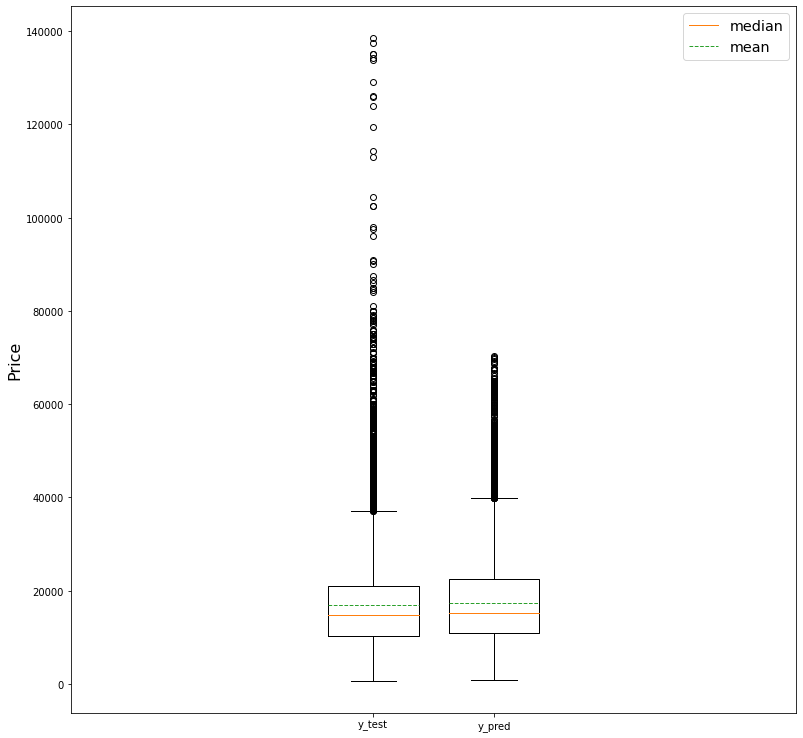

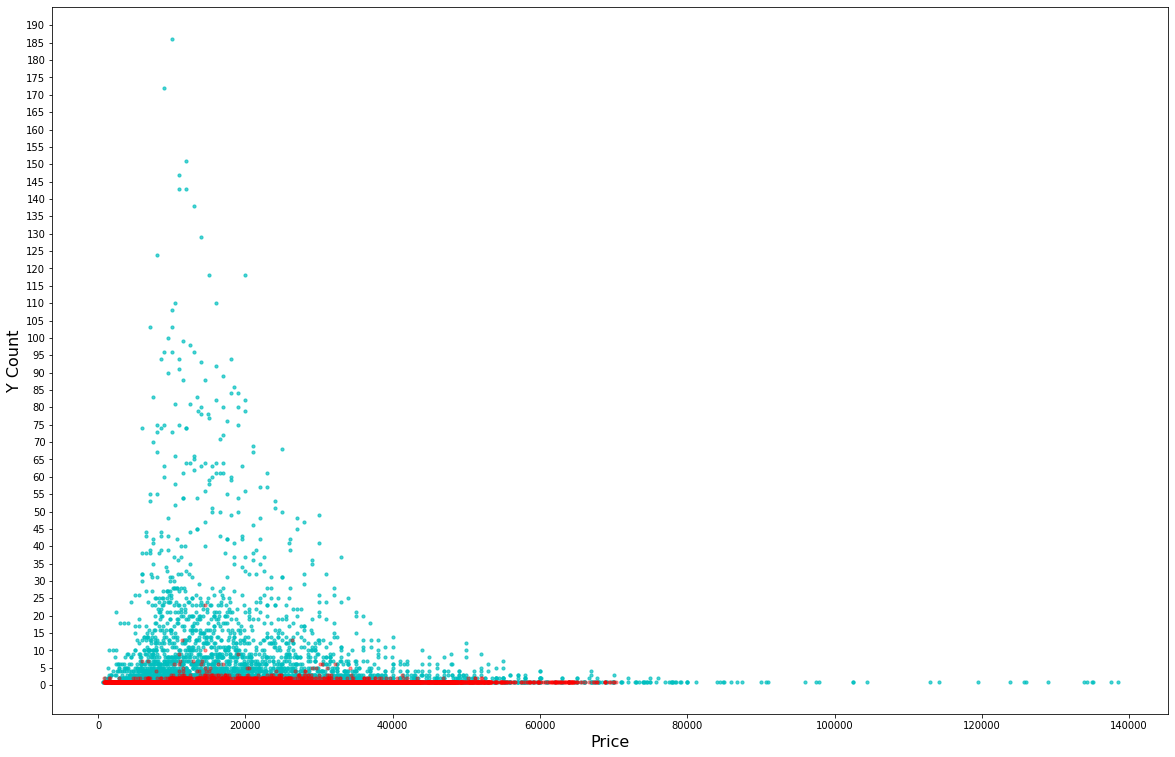

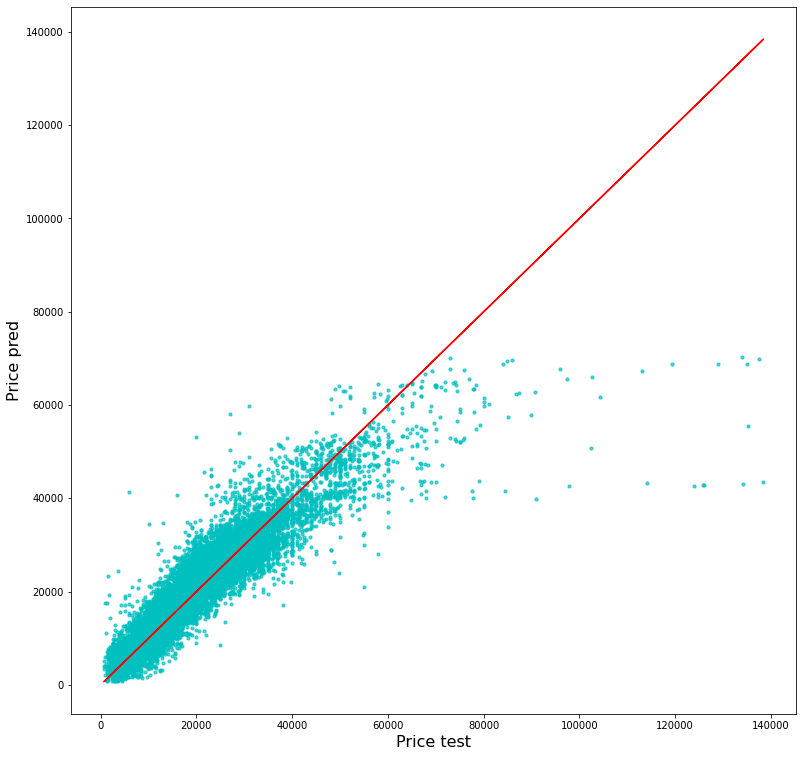

time: 1.09 s (started: 2021-06-17 20:41:56 +00:00)


In [ ]:
print_results(y_test, y_pred)


#Conclusiones
Todos los Algoritmos podrian ser validos ya que convergen excepto el alogritmo de SGD. El algoritmo que mejor se adapta para este caso de uso es el random forest ya que al no ser una regresion lineal puede adecuarse mejor a los diferentes datos que le entran desde el modelo. Además con randomForest logramos mejores resultados que con la regresión Polinómica, ya que, aunque esta consigue adaptarse mucho mejor al modelo que una regresión lineal simple, carece de la libertad que tiene un random forest de hacer diferentes clasificaciones en diferentes zonas: como no predecir ningún valor negativo ,o adaptarse mejor a los outliers

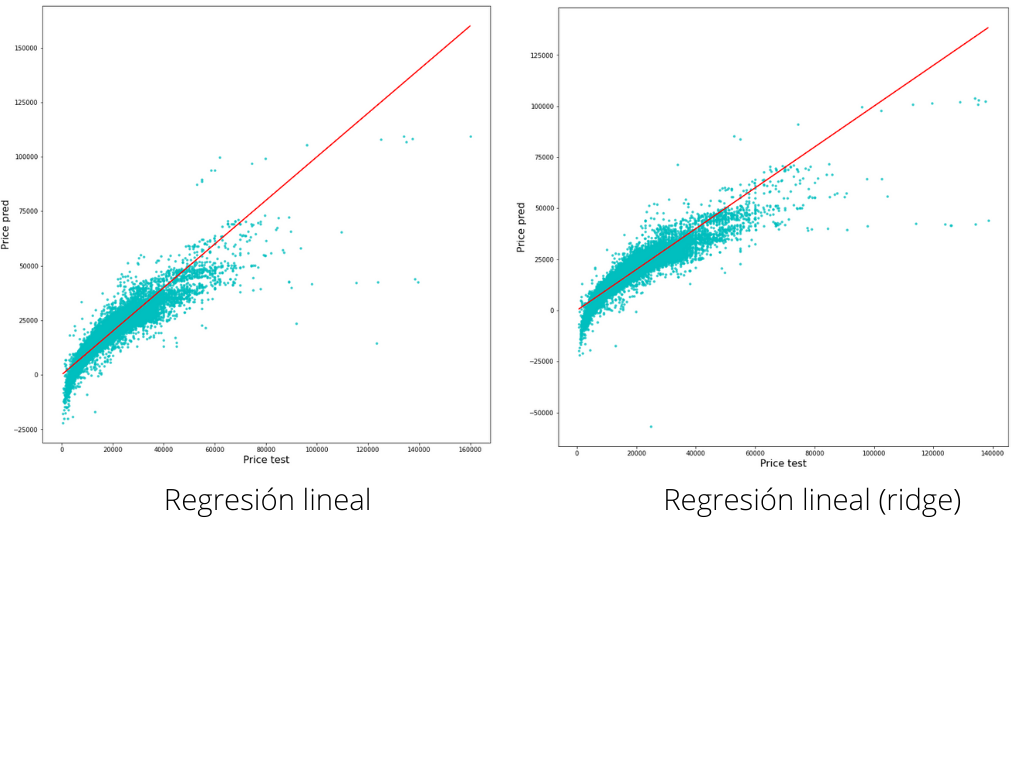

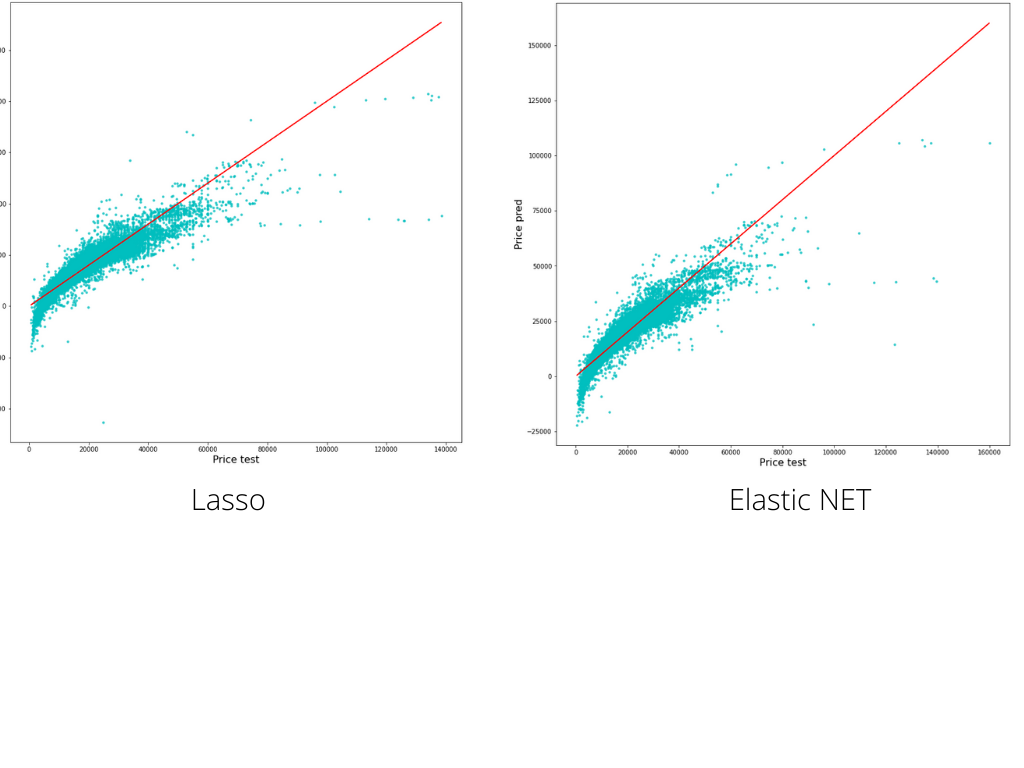

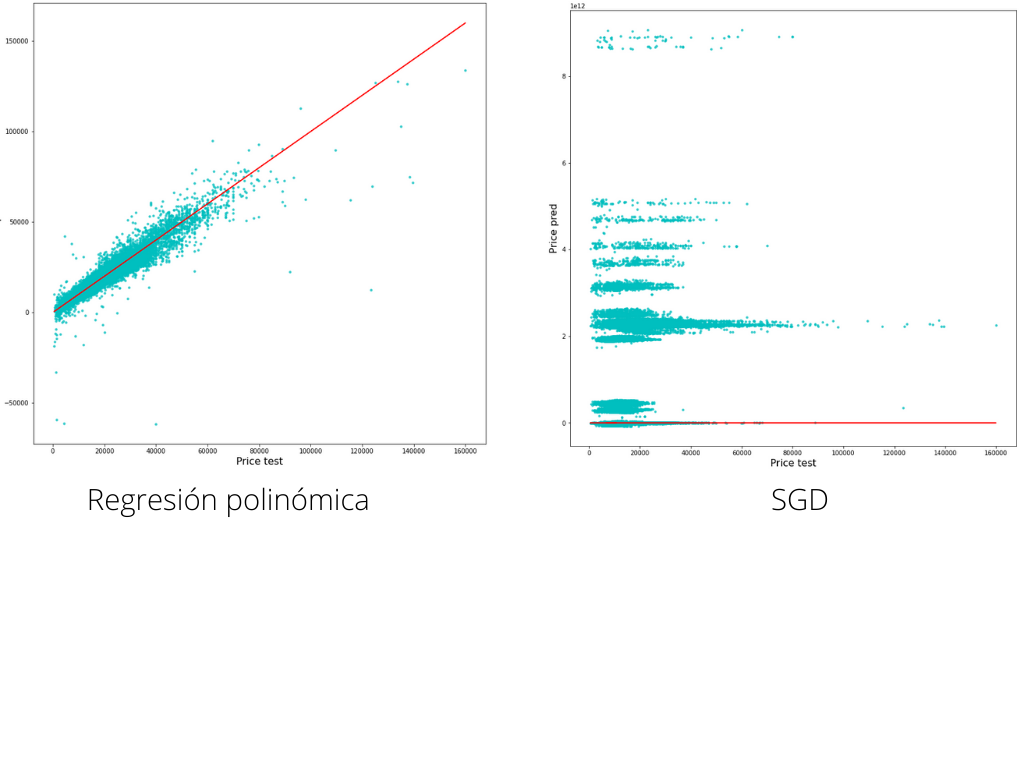

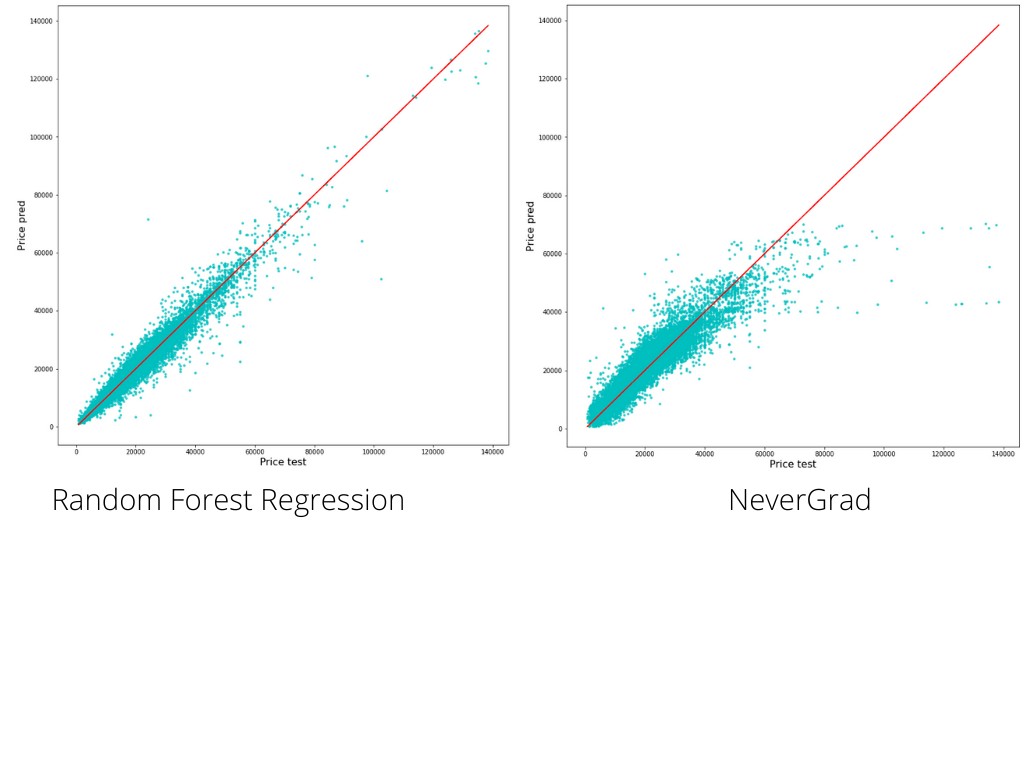